# Cifar 10 CNN-el

## 1.) Inicializáló rész

Használjuk fel az eddigi inicializációt megint, ami most módosulni fog, hogy beimportálunk olyan rétegeket is a Keras.layers-ből, melyek elengedhetetlenek egy konvolúciós hálóhoz (Conv2D, Pooling, stb.)

In [1]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.095
session = tf.Session(config=config) # Letrehozunk egy TF session-t a megfelelo mem. korlattal
K.set_session(session) # atadjuk azt a Kerasnak

Using TensorFlow backend.


In [2]:
import numpy as np
import math
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D 
from keras.layers import Concatenate, Lambda, Average, Add, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from random import sample as RS
from keras.metrics import top_k_categorical_accuracy

def inTop3(x,y):
    return(top_k_categorical_accuracy(x,y,k=3))

In [3]:
from keras.datasets import cifar10

def mintak_cifar10():
    (x_tan,y_tan),(x_tst,y_tst)=cifar10.load_data()
    x_tan=x_tan.astype('float32')/255.0
    x_tst=x_tst.astype('float32')/255.0
    classes=['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    idx=RS(set(range(y_tan.size)),5)
    print('Mintakepek es a cimkeik: '+str([x[0] for x in y_tan[idx]]))
    print('Cimkehez tartozo osztalyok: '+str([classes[x[0]] for x in y_tan[idx]]))
    
    (f, sf)=plt.subplots(1, 5)
    f.set_size_inches(16, 6)
    
    for i in range(5):
        img = x_tan[idx[i]]
        sf[i].imshow(img)
    plt.show()
    
    y_tan=to_categorical(y_tan).astype('float32')
    y_tst=to_categorical(y_tst).astype('float32')
    return(x_tan,y_tan,x_tst,y_tst,classes)

def halo_mentes(model,nev):
    model_json=model.to_json()
    with open(nev+'.json','w') as json_file:
        json_file.write(model_json)
    model.save_weights(nev+'.hdf5')

Olvassuk be az adathalmazt

Mintakepek es a cimkeik: [1, 8, 9, 8, 9]
Cimkehez tartozo osztalyok: ['auto', 'ship', 'truck', 'ship', 'truck']


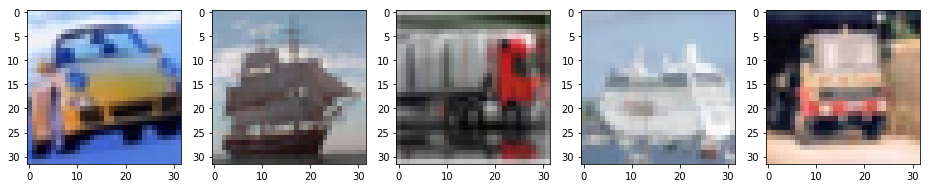

In [4]:
(x_tan,y_tan,x_tst,y_tst,cimke)=mintak_cifar10()

## 2.) Háló konstrukciója és tanítása

### Önálló feladat - egészítsük ki a konvolúciós háló struktúráját definiáló függvényt

A háló architetkrúája az alábbiak szerint nézzen ki:
- 4db 2D konvolúciós réteg 32 db 3×3-as konvolúciós / 5×5-ös konvolúció felváltva, ReLu aktivációval, azonos méretűre paddeléssel
- 4×4-es MaxPooling réteg
- 128 neuront tartalmazó teljesen összekötött réteg ReLu nemlinearitással
- 10 neuront tartalmazó teljesen összekötött réteg softmax nemlinearitással

Segítség: Keras rétegek dokumentációja - https://keras.io/layers/core/


In [5]:
def get_CNN(x_tst,y_tst):
    bem= Input(shape=x_tst[1].shape, dtype='float32')
    x=Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(bem)
    x=Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x=Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x=Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x=MaxPooling2D(pool_size=(4, 4))(x)
    y=Flatten()(x)
    y=Dense(128, activation='relu')(y)
    y=Dense(10, activation='softmax')(y)
    
    model = Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
    print(model.summary())
    
    return model

Használjuk fel az előző notebookban már megírt tanító függvényünket: korai leállás a legjobb validációs eredményhez tartozó háló súlyainak a visszatöltésével.

In [6]:
def tanitas_earlystop(model, x_tan, y_tan, epn, tol):
    
    model_checkpoint = ModelCheckpoint('CNN.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
    earlystop=EarlyStopping(monitor='val_loss', patience=tol)
    hst=model.fit(x=x_tan, y=y_tan, verbose=1, batch_size=32, epochs=epn, callbacks=[earlystop, model_checkpoint], validation_split=0.1)
    model.load_weights('CNN.hdf5')
    
    plt.title('Tanito gorbek')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    epn=len(hst.history['loss'])
    
    epi=np.linspace(1,epn,epn)
    plt.plot(epi, hst.history['loss'], 'b-', epi, hst.history['val_loss'], 'r-')
    plt.legend(['tanito', 'validacios'], loc='upper left')
    plt.show()
    return model

Hozzuk létre, és tanítsuk be a CNN hálót.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

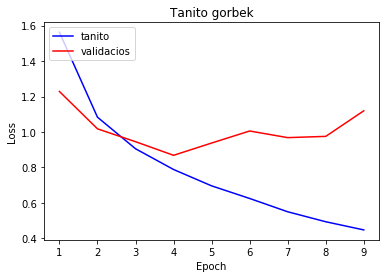

In [7]:
cnn=get_CNN(x_tan,y_tan)
cnn=tanitas_earlystop(cnn, x_tan, y_tan, 15, 5)
halo_mentes(cnn,'cnn_alap')

Érdemes összehasonlítani az imént betanított CNN pontosságát az MLP-ével:
- MLP: 1.2233-as tanító és 1.4045-ös validációs loss (0.5-ös validációs pontossággal); 820874 súly
- CNN: 0.6598-as tanító és 0.8968-os validációs loss (0.7-es validációs pontossággal); 324970 súly

Egyértelműen látszik az eltolás invariáns szűrők hatásossága...
Továbbá érdemes megfigyelni a tan<tandó súlyok hálón belüli megoszlását, főleg az első teljesen összekötött rétegben helyezkednek el.

## 3.) Regularizáció

A tanítási görbékből egyértelműen látszik, hogy az architektúra még képes lenne pontosabban megtanulni az általa látott mintákat, viszont ez már túltanulást eredményez (tehát a tanítóminták specialitásait tanulná a háló, nem a probléma általános, domén szintű jellemzőit). Ekkor jut fontos szerephez a regularizáció.

### Adat augmentáció 

Augmentáció során hiteles, probléma doménjébe illeszkedő, de mesterséges mintákat hozunk létre. Ezt olyan torzítások, transzformációk alkalmazásával érjük el, melyekre érzéketlennek kell lennie a hálónak (ideális esetben).

In [17]:
from keras.preprocessing.image import ImageDataGenerator

def tanitas_augment(model, x, y, epn, tol, ar=0.9, bm=32):
    datagen=ImageDataGenerator(rotation_range=20, width_shift_range=0, 
                               height_shift_range=0, shear_range=0.2, 
                               zoom_range=0.2, horizontal_flip=True, 
                               fill_mode='nearest')
    
    N=x.shape[0]
    Nk=round(N*ar)
    idx=set(range(N))
    idxt=RS(idx,Nk)
    idxv=list(idx-set(idxt))
    x_tan=x[idxt]
    y_tan=y[idxt]
    x_val=x[idxv]
    y_val=y[idxv]
       
    tstim=x_tan[259]
    tmp3=datagen.flow(tstim[None,], batch_size=1)
    print('Eredeti kep:')
    plt.imshow(tstim)
    plt.show()
    print()
    print('Augmentalt kepek:')
    (f,sf)=plt.subplots(nrows=2, ncols=3, figsize=(6, 6))
    for i in range(2):
        for j in range(3):
            img=next(tmp3)
            sf[i,j].imshow(img[0])
    plt.show()
    
    model_checkpoint = ModelCheckpoint('cnn_aug.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
    earlystop=EarlyStopping(monitor='val_loss', patience=tol)
    model.fit_generator(generator=datagen.flow(x_tan,y_tan, batch_size=bm), steps_per_epoch=Nk//bm, epochs=epn, callbacks=[model_checkpoint, earlystop], validation_data=(x_val, y_val))
    model.load_weights('cnn_aug.hdf5')
    return(model)


Eredeti kep:


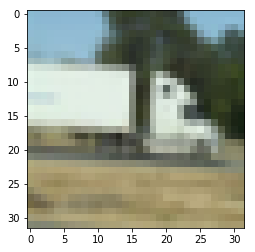


Augmentalt kepek:


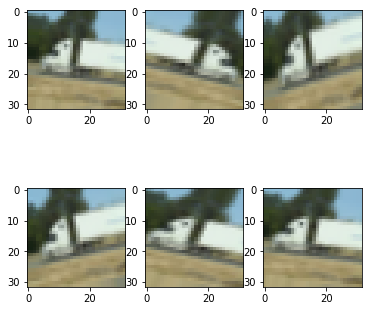

Epoch 1/25
1406/1406 [==============================] - 16s 12ms/step - loss: 1.0087 - acc: 0.6475 - inTop3: 0.8955 - val_loss: 0.8578 - val_acc: 0.7070 - val_inTop3: 0.9204

Epoch 00001: val_loss improved from inf to 0.85779, saving model to cnn_aug.hdf5
Epoch 2/25
1406/1406 [==============================] - 17s 12ms/step - loss: 0.9517 - acc: 0.6671 - inTop3: 0.9042 - val_loss: 0.7516 - val_acc: 0.7394 - val_inTop3: 0.9382

Epoch 00002: val_loss improved from 0.85779 to 0.75164, saving model to cnn_aug.hdf5
Epoch 3/25
1406/1406 [==============================] - 17s 12ms/step - loss: 0.9127 - acc: 0.6818 - inTop3: 0.9131 - val_loss: 0.8509 - val_acc: 0.7020 - val_inTop3: 0.9266

Epoch 00003: val_loss did not improve from 0.75164
Epoch 4/25
1406/1406 [==============================] - 17s 12ms/step - loss: 0.8865 - acc: 0.6921 - inTop3: 0.9143 - val_loss: 0.7747 - val_acc: 0.7248 - val_inTop3: 0.9372

Epoch 00004: val_loss did not improve from 0.75164
Epoch 5/25
1406/1406 [==========

In [18]:
cnn=tanitas_augment(cnn, x_tan, y_tan, 25, 10)

12 epochnyi tanítás után tovább javul a validációs hiba:
0.7591-as tanító és 0.8014-es validációs loss (0.75-ös validációs pontossággal); 273706 súly

### Dropout rétegekkel a háló bővítése

Regularizáció másik, mély hálóknál gyakran alkalmazott változata a dropout rétegek alkalmazása. Ennek során az egyes konvolkúciós szűrőket véletlenszerűen dobálja ki a tanítás (persze ennek a valószínűségét meg tudjuk előre adni). A rétegek használatával a szűrések által kiemelt jellemzők redundánsabbak lesznek, ezáltal egy-egy kiemelés hibájára kevésbé lesznek érzékenyek.

#### Önálló feladat - új háló definiálása, mely struktúrája megegyezik az eddigivel, de minden szűrés után 0.2-es valséggel dob ki egy-egy csatornát

In [28]:
def get_CNNDo(x_tst,y_tst):
    bem= Input(shape=x_tst[1].shape, dtype='float32')
    x=Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(bem)
    x=Dropout(0.5)(x)
    x=Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x=Dropout(0.5)(x)
    x=Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x=Dropout(0.5)(x)
    x=Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x=MaxPooling2D(pool_size=(4, 4))(x)
    y=Flatten()(x)
    y=Dense(128, activation='relu')(y)
    y=Dense(10, activation='softmax')(y)
    
    model = Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
    print(model.summary())
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
__________

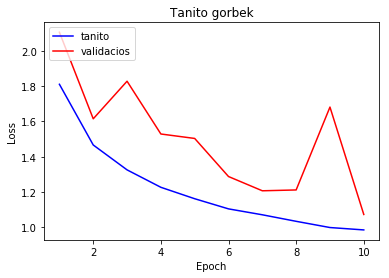

In [29]:
cnndo=get_CNNDo(x_tan,y_tan)
cnndo=tanitas_earlystop(cnndo, x_tan, y_tan, 10, 3)

Train on 45000 samples, validate on 5000 samples
Epoch 1/40
45000/45000 [==============================] - 12s 275us/step - loss: 0.9548 - acc: 0.6639 - inTop3: 0.9076 - val_loss: 1.0230 - val_acc: 0.6510 - val_inTop3: 0.8936

Epoch 00001: val_loss improved from inf to 1.02300, saving model to CNN.hdf5
Epoch 2/40
45000/45000 [==============================] - 12s 274us/step - loss: 0.9352 - acc: 0.6707 - inTop3: 0.9122 - val_loss: 1.1931 - val_acc: 0.5970 - val_inTop3: 0.8630

Epoch 00002: val_loss did not improve from 1.02300
Epoch 3/40
45000/45000 [==============================] - 12s 273us/step - loss: 0.9256 - acc: 0.6730 - inTop3: 0.9124 - val_loss: 1.2979 - val_acc: 0.5670 - val_inTop3: 0.8500

Epoch 00003: val_loss did not improve from 1.02300
Epoch 4/40
45000/45000 [==============================] - 12s 275us/step - loss: 0.9078 - acc: 0.6819 - inTop3: 0.9171 - val_loss: 0.9649 - val_acc: 0.6596 - val_inTop3: 0.9002

Epoch 00004: val_loss improved from 1.02300 to 0.96494, savi

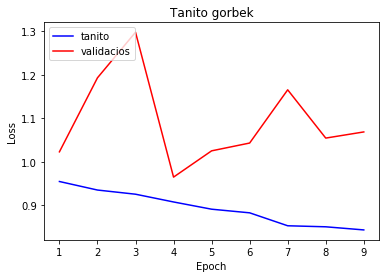

In [30]:
cnndo=tanitas_earlystop(cnndo, x_tan, y_tan, 40, 5)
halo_mentes(cnn,'cnn_dropout')

Látványos eredményt esetünkben nem hozott a dropout rétegek használata. Ennek legfőbb magyarázata, hogy túl kicsi az általunk most használt háló. 

## 4.) Háló mélységének a növelése

Mivel az előző feladatok során a háló kis mérete valszűleg korlátozza az elérhető pontosságot, ezért logikus lépés annak a növelése.

#### Önálló feladat - paraméterként átadható mélységű háló létrehozása

In [36]:
def get_CNNmely(x_tst,y_tst,bb,kb):
    bem= Input(shape=x_tst[1].shape, dtype='float32')
    x=bem
    fsz=16
    kb=min(kb, math.floor(np.log2(x_tst.shape[2]))-1)
    for i in range(kb):
        for j in range(bb):
            x=Conv2D(filters=fsz, kernel_size=(3, 3), activation='relu', padding='same')(x)
        
        x=MaxPooling2D(pool_size=(2, 2))(x)
        fsz=fsz*2
        
    y=Flatten()(x)
    y=Dense(128, activation='relu')(y)
    y=Dense(10, activation='softmax')(y)
    
    model = Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
    print(model.summary())
    
    return model 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 16, 16, 32)        9248      
__________

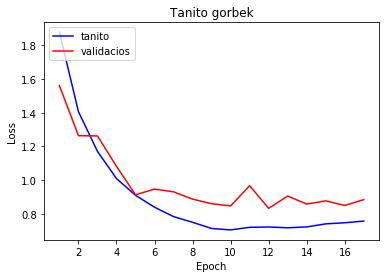

In [40]:
cnn_m=get_CNNmely(x_tan,y_tan,3,4)
nndo=tanitas_earlystop(cnn_m, x_tan, y_tan, 20, 5)
halo_mentes(cnn,'cnn_mely')

Több mint 0.05-el sikerült csökkenteni a validacios hibat.

### Residual blokkok használata

#### Önálló feladat - belső blokkok bővítése skipp connection-nel

Várhatóan tovább javítható a háló pontossága, illetve növelhető a tanulás sebssége, ha residual blokkokba szervezzük az előzőleg definiált belső blokkjainkat.

In [44]:
def get_CNNres(x_tst,y_tst,bb,kb):
    bem= Input(shape=x_tst[1].shape, dtype='float32')
    x=bem
    fsz=16
    kb=min(kb, math.floor(np.log2(x_tst.shape[2]))-1)
    for i in range(kb):
        x=Conv2D(filters=fsz, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x2=x
        for j in range(bb-1):
            x2=Conv2D(filters=fsz, kernel_size=(3, 3), activation='relu', padding='same')(x2)
        
        x2=Add()([x, x2])
        x=MaxPooling2D(pool_size=(2, 2))(x2)
        fsz=fsz*2
        
    y=Flatten()(x)
    y=Dense(128, activation='relu')(y)
    y=Dense(10, activation='softmax')(y)
    
    model = Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
    print(model.summary())
    
    return model 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 32, 16)   448         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 32, 32, 16)   2320        conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 16)   2320        conv2d_63[0][0]                  
__________________________________________________________________________________________________
add_1 (Add

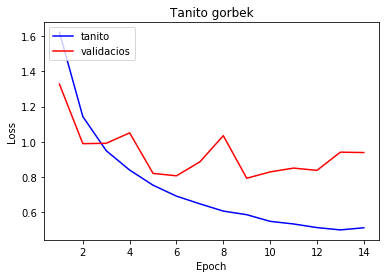

In [45]:
cnn_m=get_CNNres(x_tan,y_tan,3,4)
nndo=tanitas_earlystop(cnn_m, x_tan, y_tan, 20, 5)
halo_mentes(cnn_m,'cnn_res')

Tanítsuk egy kicsit augmentált adatokkal is a hálót.

Eredeti kep:


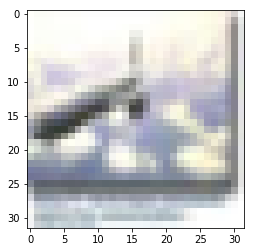


Augmentalt kepek:


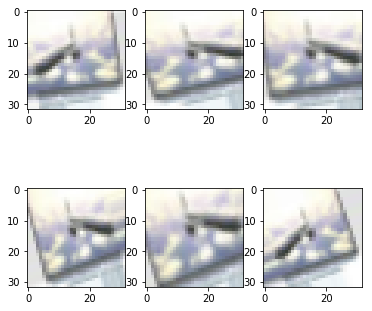

Epoch 1/25
1406/1406 [==============================] - 18s 13ms/step - loss: 0.9490 - acc: 0.6731 - inTop3: 0.9017 - val_loss: 0.7106 - val_acc: 0.7574 - val_inTop3: 0.9360

Epoch 00001: val_loss improved from inf to 0.71058, saving model to cnn_aug.hdf5
Epoch 2/25
1406/1406 [==============================] - 18s 13ms/step - loss: 0.9122 - acc: 0.6850 - inTop3: 0.9075 - val_loss: 0.7609 - val_acc: 0.7410 - val_inTop3: 0.9364

Epoch 00002: val_loss did not improve from 0.71058
Epoch 3/25
1406/1406 [==============================] - 18s 13ms/step - loss: 0.8777 - acc: 0.6969 - inTop3: 0.9113 - val_loss: 0.7996 - val_acc: 0.7350 - val_inTop3: 0.9348

Epoch 00003: val_loss did not improve from 0.71058
Epoch 4/25
1406/1406 [==============================] - 18s 13ms/step - loss: 0.8643 - acc: 0.7027 - inTop3: 0.9131 - val_loss: 0.7658 - val_acc: 0.7392 - val_inTop3: 0.9330

Epoch 00004: val_loss did not improve from 0.71058
Epoch 5/25
1406/1406 [==============================] - 18s 13ms/s

In [48]:
cnn_m=tanitas_augment(cnn_m, x_tan, y_tan, 25, 10)
halo_mentes(cnn_m,'cnn_res_aug')

Eddigi legjobb pontosságot így értük el: 0.7-es validacios loss-al, és 75 % feletti validacios pontossággal.
Kérdés: dropout alkalmazása hogyan lenne célszerű?

## 5.) Háló tesztelése

A már ismert módon teszteljük le a betanított hálót!

In [51]:
from sklearn.metrics import confusion_matrix

def teszt(halo, x_test, y_test):
    
    tmp=halo.evaluate(x_test,y_test)
        
    y_pred=np.argmax(halo.predict(x_test),axis=1)
    print('Confusion Matrix:')
    print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
    print()
    print('Loss:'+str(tmp[0])+'; Acc:'+str(tmp[1])+'; Top3Acc:'+str(tmp[2]))
    print()
    return({'loss':tmp[0], 'acc':tmp[1], 'top3acc':tmp[2]})

In [52]:
teszt(cnn_m,x_tst,y_tst)

10000/10000 [==============================] - 1s 121us/step
Confusion Matrix:
[[753  17  42  12  20   4   6  16  67  63]
 [  9 844   1   2   4   3   4   2  22 109]
 [ 66   3 559  40 132  41  86  42  16  15]
 [ 27  16  51 447 100 103 116  64  34  42]
 [ 20   2  47  22 739  14  84  62   6   4]
 [ 12   5  40 174  71 491  71  93  17  26]
 [  6   9  26  29  40  10 843   9  18  10]
 [ 15   6  22  25  61  38  12 788   2  31]
 [ 56  15   6   4  12   2   2   6 846  51]
 [ 14  57   2   4  10   6   3   9  17 878]]

Loss:0.8453566763877869; Acc:0.7188; Top3Acc:0.9225



{'loss': 0.8453566763877869, 'acc': 0.7188, 'top3acc': 0.9225}

In [53]:
K.clear_session()